In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
signal = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [4]:
varinfo.clear()

In [5]:
filter_eightb = CollectionFilter('jet', filter=lambda t: ( ak.argsort(ak.argsort(-t.jet_btag,axis=-1)) < 8 ) )

signal = signal.apply(filter_eightb)
qcd = qcd.apply(filter_eightb)

In [6]:
(signal+qcd).apply(build_all_dijets)

[None, None]

In [7]:
def build_all_quadh(tree):
  dijets = get_collection(tree,'dijet',False)[['pt','m','signalId']]
  quadh = dijets[:, eightb.quadh_index]
  quadh = quadh[ak.argsort(-quadh.pt, axis=-1)]

  maxim = ak.max(quadh.m,axis=-1)
  minim = ak.min(quadh.m,axis=-1)
  asym = (maxim-minim)/(maxim+minim)
  nhiggs = ak.sum(quadh.signalId>-1, axis=-1)

  quadh = rename_collection(quadh, 'quadh')
  tree.extend(quadh, quadh_asym=asym, quadh_nhiggs=nhiggs)
(signal+qcd).apply(build_all_quadh)

[None, None]

In [8]:
import awkward0 as ak0, glob

# path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_pure/output/"
path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/"

def load_rank_output(path):
    output = ak0.load(path)
    scores = output['scores']
    return ak.from_regular(scores.reshape(-1, 105))

def load_regex_output(regex, load):
    print(glob.glob(regex))
    path = glob.glob(regex)[0]
    return load(path)

In [9]:
def load_signal_output(tree):
    mass = tree.sample
    scores = {
        'quadh_score':{'path':path,'score':[],'load':load_rank_output},
    }
    for key, info in scores.items():
        info['score'] = load_regex_output(f'{info["path"]}/*{mass}*', info["load"])
    scores = { key:info['score'] for key,info in scores.items() }
    tree.extend(**scores)

signal.apply(load_signal_output)

['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/NMSSM_XYY_YToHH_8b_MX_1000_MY_450_accstudies.awkd']


[None]

In [10]:
def load_bkg_output(tree):
  scores = {
    'quadh_score':{'path':path,'score':[],'load':load_rank_output},
    # 'class_score':{'path':class_path,'score':[],'load':load_class_output}
  }
  for f in tree.filelist:
    for key, info in scores.items():
      info['score'].append( load_regex_output(f'{info["path"]}/{f.sample}*', info['load']) )
  scores = { key:ak.concatenate(info['score']) for key,info in scores.items() }
  tree.extend(**scores)

qcd.apply(load_bkg_output)

['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_dijet_p4/output/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgrap

[None]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


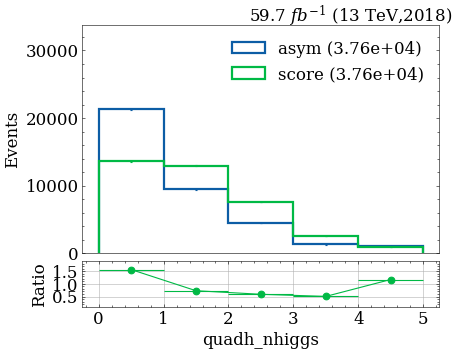

In [11]:
study.quick(
  signal[[0,0]], h_color=None, label=['asym','score'], legend=True,
  indicies=[
    lambda t:ak.argmin(t.quadh_asym,axis=-1, keepdims=True),
    lambda t:ak.argmax(t.quadh_score,axis=-1, keepdims=True)
    ],
  varlist=['quadh_nhiggs'],

  ratio=True,
)

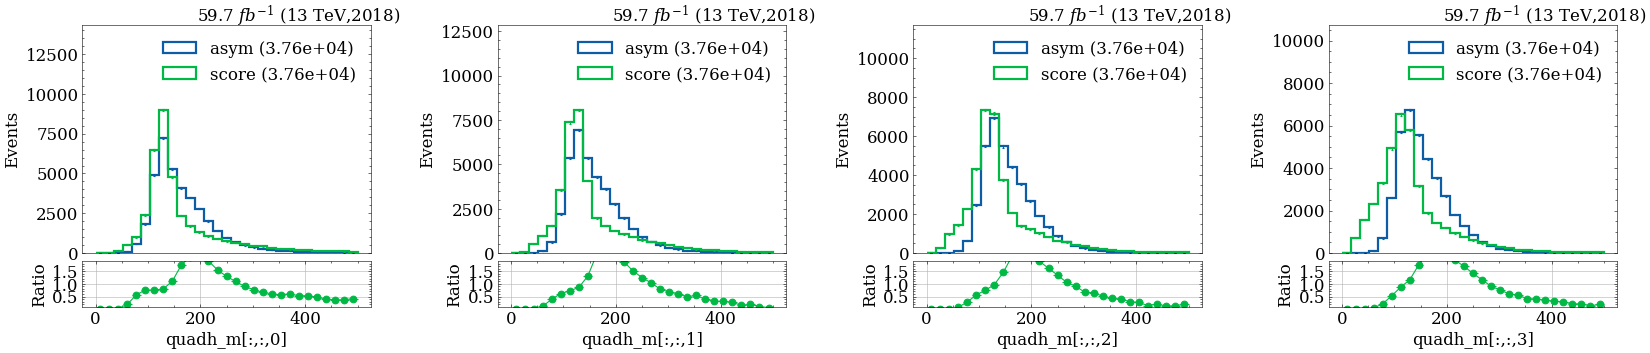

In [12]:
study.quick(
  signal[[0,0]], h_color=None, label=['asym','score'], legend=True,
  indicies=[
    lambda t:ak.argmin(t.quadh_asym,axis=-1, keepdims=True),
    lambda t:ak.argmax(t.quadh_score,axis=-1, keepdims=True)
    ],
  varlist=['quadh_m[:,:,0]','quadh_m[:,:,1]','quadh_m[:,:,2]','quadh_m[:,:,3]'],
  binlist=[(0,500,30)]*4,
  dim=(-1,4),
  ratio=True,
)

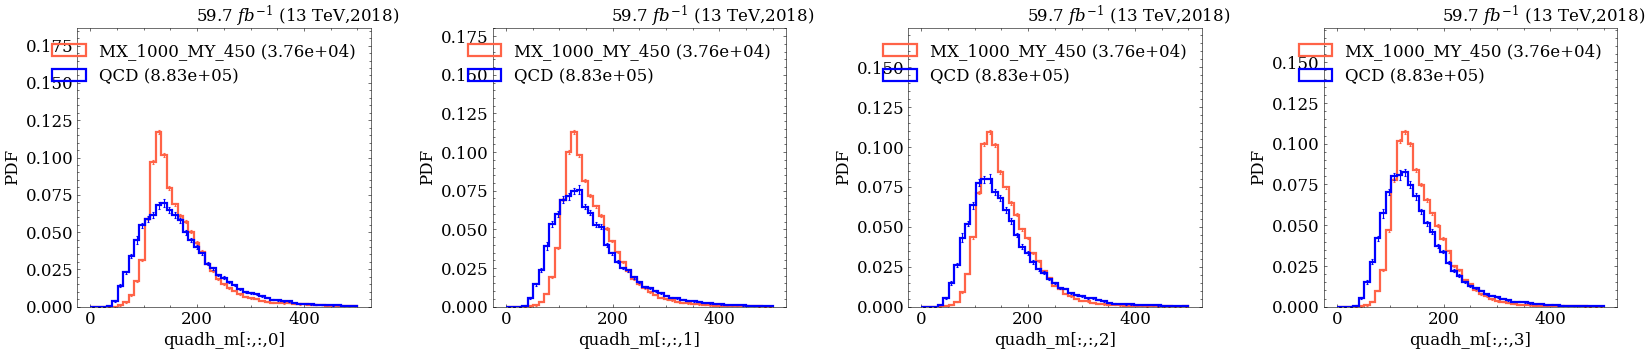

In [13]:
study.quick(
  signal+qcd,  legend=True,
  indicies=lambda t:ak.argmin(t.quadh_asym,axis=-1, keepdims=True),
  varlist=['quadh_m[:,:,0]','quadh_m[:,:,1]','quadh_m[:,:,2]','quadh_m[:,:,3]'],
  binlist=[(0,500,50)]*4,
  density=True,

  dim=(-1,4), 

)

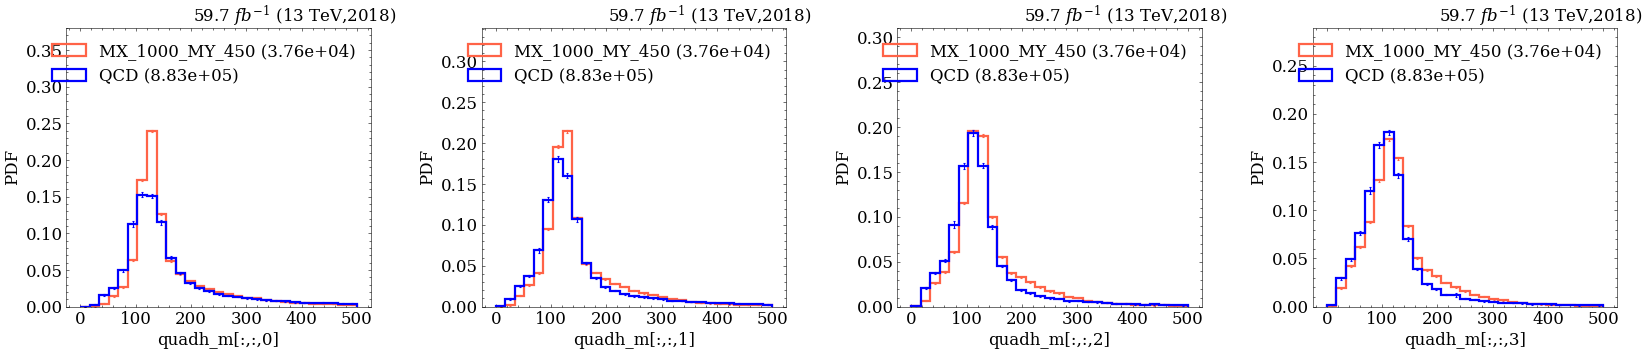

In [14]:
study.quick(
  signal+qcd,  legend=True,
  indicies=lambda t:ak.argmax(t.quadh_score,axis=-1, keepdims=True),
  varlist=['quadh_m[:,:,0]','quadh_m[:,:,1]','quadh_m[:,:,2]','quadh_m[:,:,3]'],
  binlist=[(0,500,30)]*4,
  density=True,

  dim=(-1,4), 
)

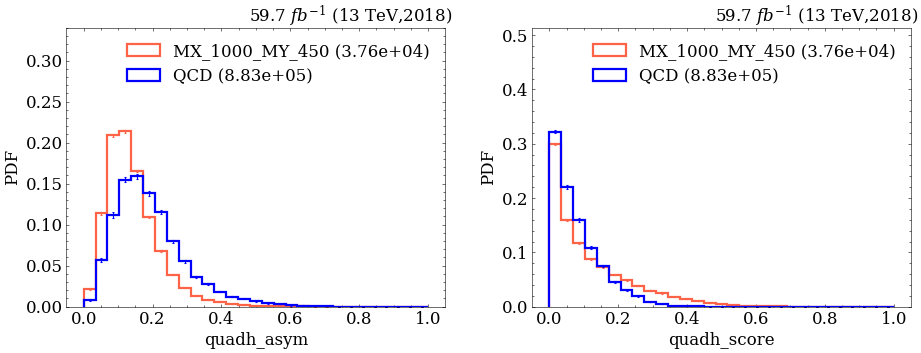

In [15]:
study.quick(
  signal+qcd,  legend=True,
  indicies=lambda t:ak.argmin(t.quadh_asym,axis=-1, keepdims=True),
  varlist=['quadh_asym','quadh_score'],
  binlist=[(0,1,30)]*2,
  density=True,
  # dim=(-1,4),
)

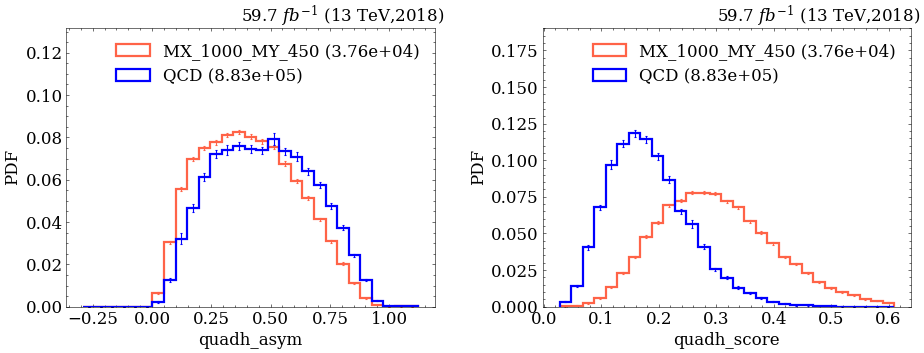

In [16]:
study.quick(
  signal+qcd,  legend=True,
  indicies=lambda t:ak.argmax(t.quadh_score,axis=-1, keepdims=True),
  varlist=['quadh_asym','quadh_score'],
  # binlist=[(0,250,30)]*4,
  density=True,
  # dim=(-1,4),
)

In [89]:
def build_best_bois(tree):
  btagavg = ak.mean(tree.jet_btag,axis=-1)
  nmedium = ak.sum( tree.jet_btag > jet_btagWP[2], axis=-1)
  maxscore = ak.max(tree.quadh_score,axis=-1)
  ptavg = ak.mean(tree.jet_pt, axis=-1)/ak.max(tree.jet_pt,axis=-1)
  tree.extend(btagavg=btagavg, maxscore=maxscore, ptavg=ptavg, nmedium=nmedium)
(signal+qcd).apply(build_best_bois)

[None, None]

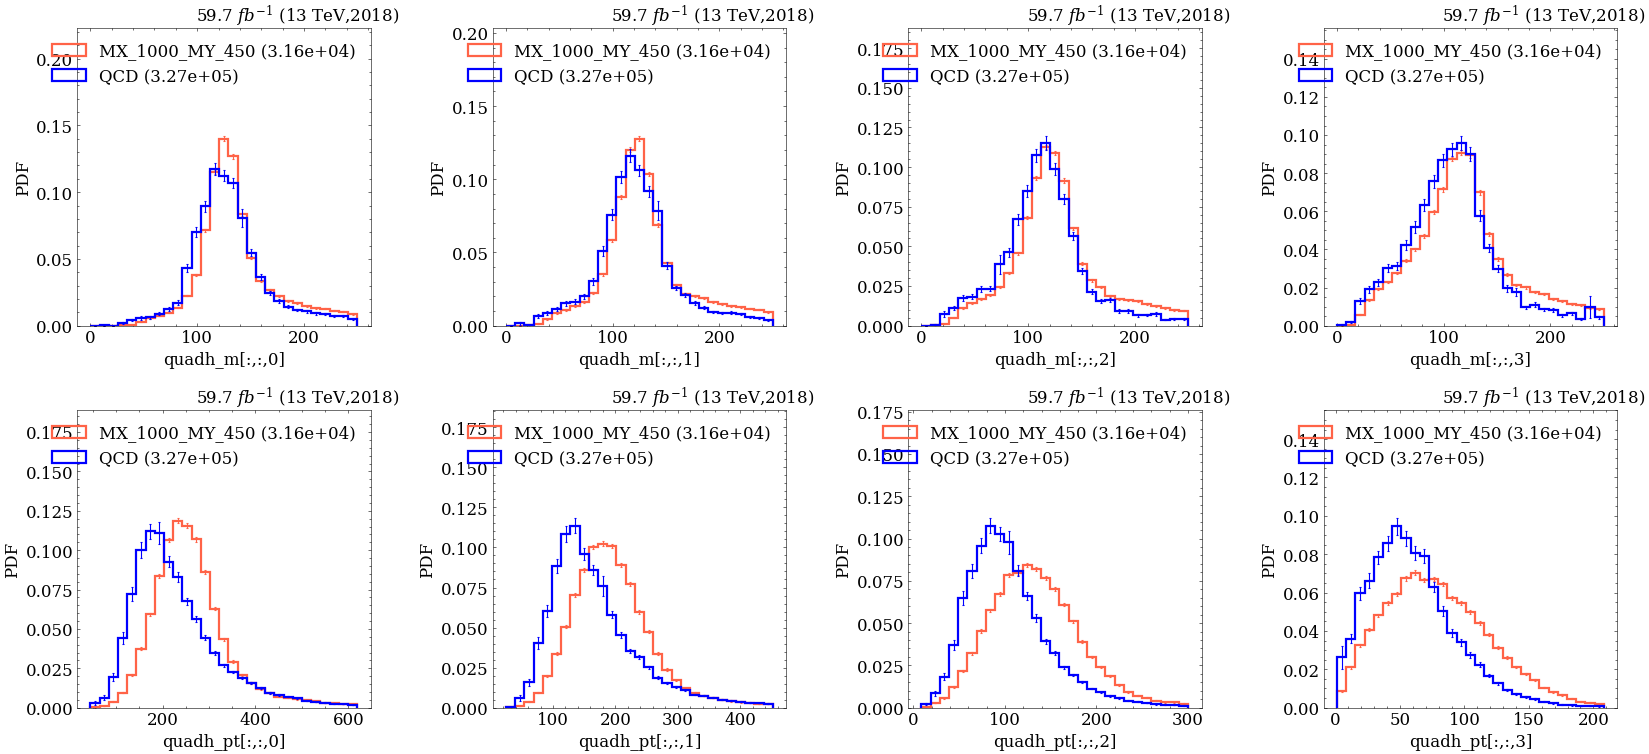

In [31]:
study.quick(
  signal+qcd,  legend=True,
  indicies=lambda t:ak.argmax(t.quadh_score,axis=-1, keepdims=True),
  masks=lambda t:t.maxscore>0.2,
  varlist=[f'quadh_{var}[:,:,{i}]' for var in ('m','pt') for i in range(4) ],
  binlist=[(0,250,30)]*4,
  density=True,
  dim=(-1,4),
)

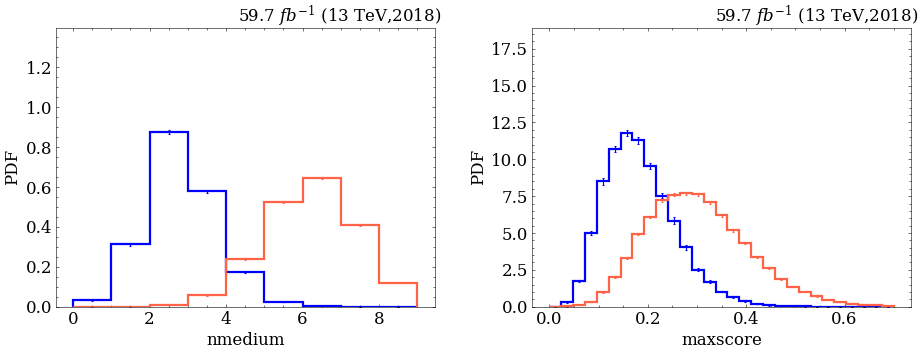

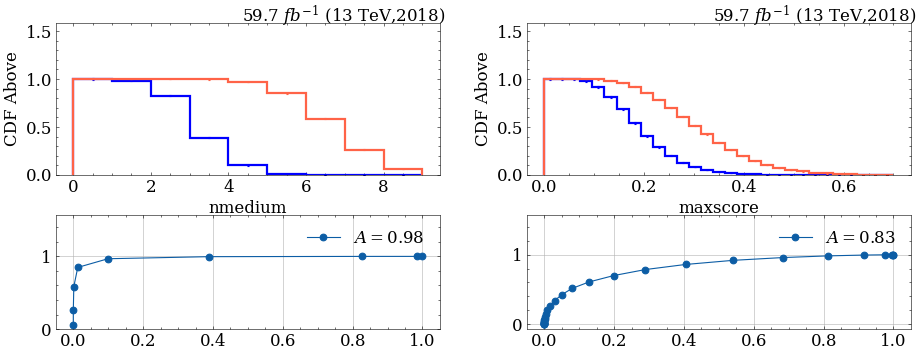

In [91]:
study.quick(
  qcd+signal, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["nmedium","maxscore",],
  binlist=[None,(0,0.7,30)],
  density=True,
  dim=(-1,2),
)

study.quick(
  qcd+signal, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["nmedium","maxscore",],
  binlist=[None,(0,0.7,30)],

  correlation=True, cumulative=-1,
)

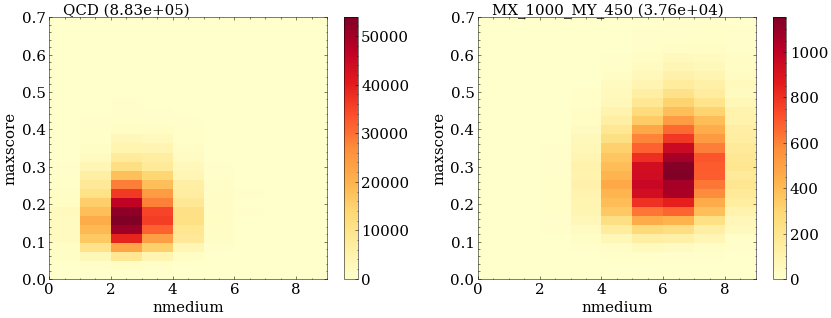

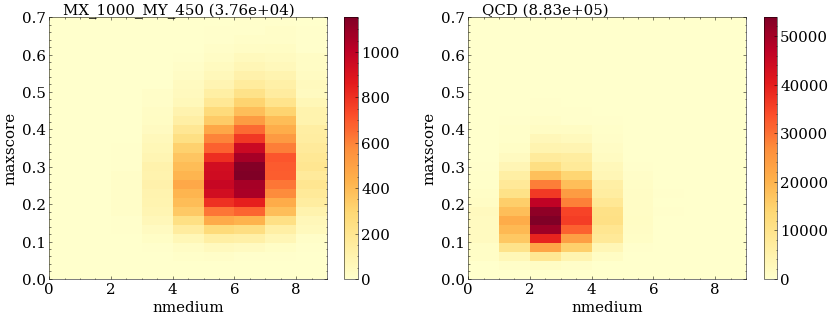

In [92]:

study.quick2d(
  qcd+signal, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["nmedium","maxscore"],
  binlist=[None,(0,0.7,30)],
)


study.quick2d(
  signal+qcd, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["nmedium","maxscore"],
  binlist=[None,(0,0.7,30)],
)

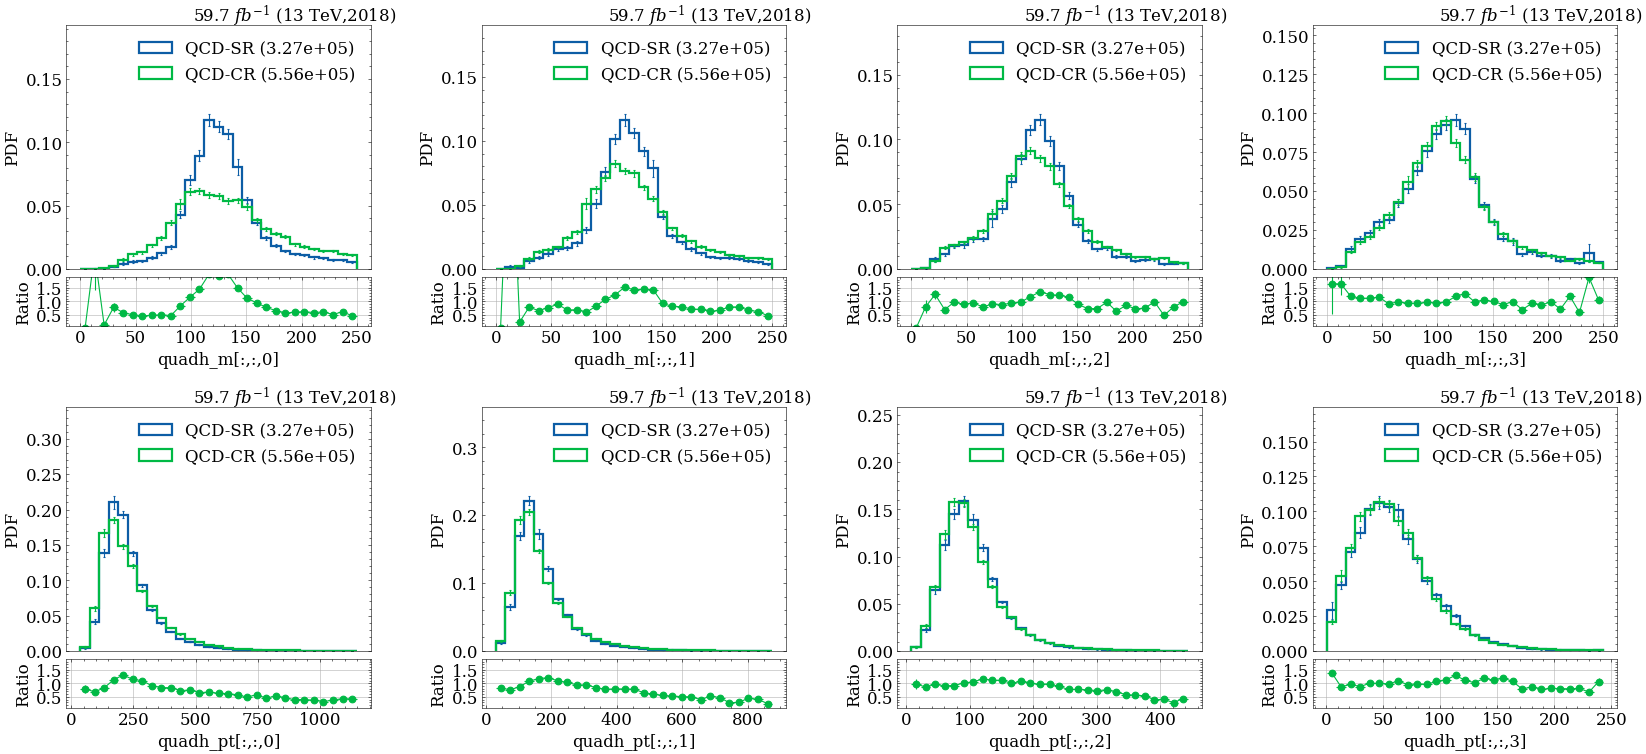

In [79]:
study.quick(
  qcd[[0,0]],h_color=None,label=['QCD-SR','QCD-CR'],  legend=True,
  indicies=lambda t:ak.argmax(t.quadh_score,axis=-1, keepdims=True),
  masks=[lambda t:ak.max(t.quadh_score,axis=-1)>0.2,lambda t:ak.max(t.quadh_score,axis=-1)<0.2],
  varlist=[f'quadh_{var}[:,:,{i}]' for var in ('m','pt') for i in range(4) ],
  binlist=[(0,250,30)]*4,
  # density=True,
  efficiency=True,
  ratio=True,
  dim=(-1,4),
)

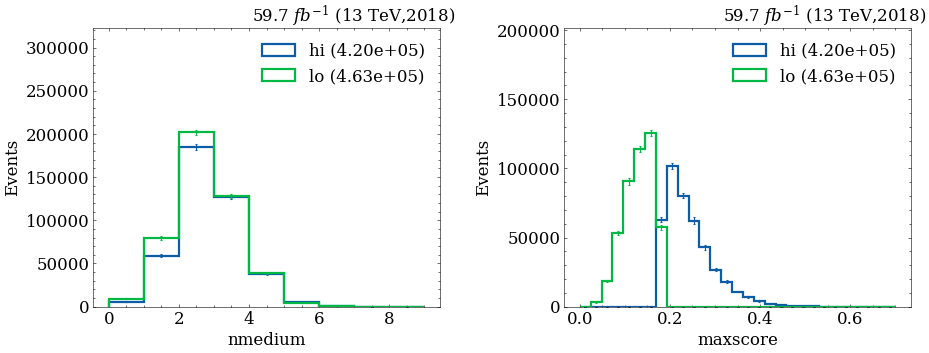

In [93]:

study.quick(
  qcd[[0,0]], h_color=None, label=['hi','lo'],legend=True,
  # masks=lambda t:t.nmedium>0.4,
  masks=[lambda t:t.maxscore>0.18,lambda t:t.maxscore<0.18],
  varlist=["nmedium","maxscore",],
  binlist=[None,(0,0.7,30)],
  dim=(-1,2),
  # density=True,
  # correlation=True, cumulative=-1,
)


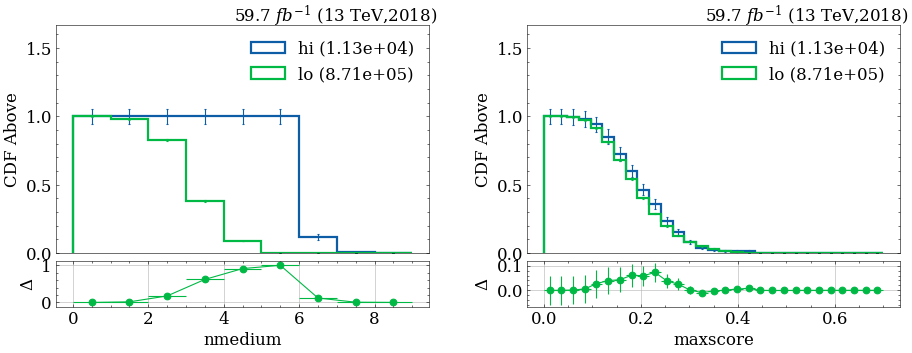

In [98]:

study.quick(
  qcd[[0,0]], h_color=None, label=['hi','lo'],legend=True,
  # masks=lambda t:t.nmedium>0.4,
  masks=[lambda t:t.nmedium>4,lambda t:t.nmedium<=4],
  varlist=["nmedium","maxscore",],
  binlist=[None,(0,0.7,30)],
  dim=(-1,2),
  # efficiency=True,
  difference=True, cumulative=-1,
)

In [190]:
def get_abcd(b_cut, s_cut, tree=qcd[0]):
  b_mask = tree.nmedium >= b_cut
  s_mask = tree.maxscore > s_cut

  scale = tree.scale
  a = ak.sum(scale[ b_mask &  s_mask])
  b = ak.sum(scale[ b_mask & ~s_mask])
  c = ak.sum(scale[~b_mask &  s_mask])
  d = ak.sum(scale[~b_mask & ~s_mask])

  return a,b,c,d

def abcd_minim(b_cut, s_cut):
  a,b,c,d = get_abcd(b_cut, s_cut)
  return np.abs(1 - (b/a)*(c/d))

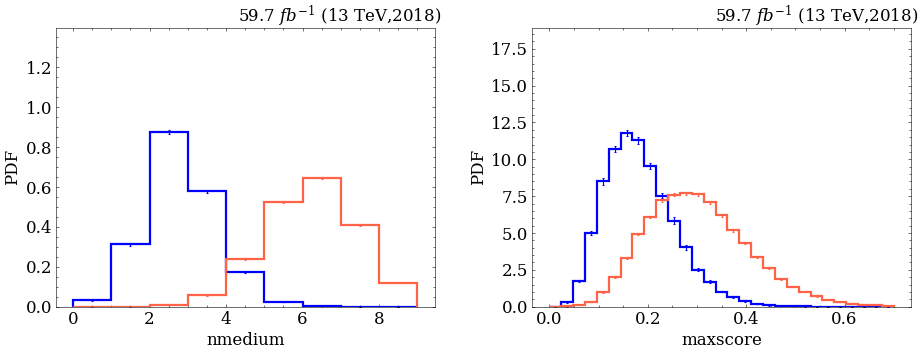

In [191]:
study.quick(
  qcd+signal, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["nmedium","maxscore",],
  binlist=[None,(0,0.7,30)],
  density=True,
  dim=(-1,2),
)

In [192]:
B = np.arange(1,7)
S = np.linspace(0.05,0.4,25)

bs, ss = np.meshgrid(B, S)
zs = np.vectorize(abcd_minim)(bs,ss)

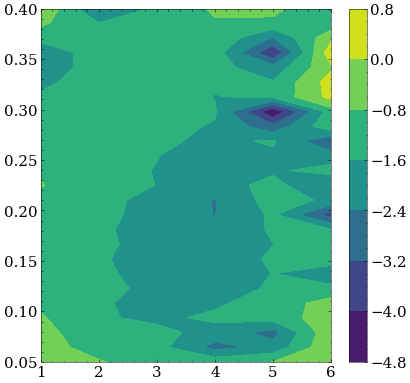

In [193]:
plt.contourf(bs, ss, np.log(zs))
plt.colorbar()

0.06346661167973822

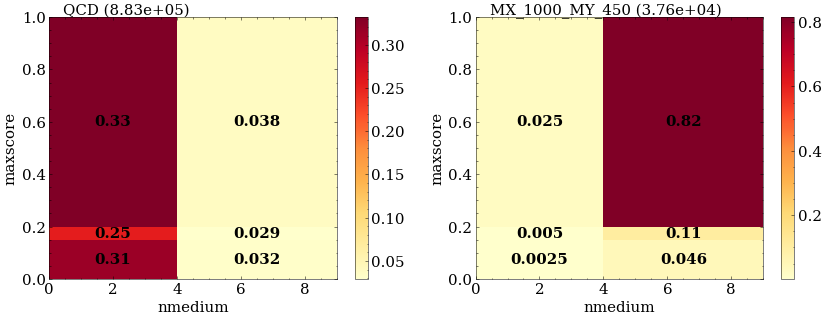

In [198]:
b_cut, s_cut = 4,0.2
sv_cut = 0.15

# study.quick(
#   qcd,
#   varlist=['nmedium','maxscore'],
#   binlist=[ np.array([0,b_cut, 9]), np.array([0,s_cut,1]) ],
#   efficiency=True,
# )

study.quick2d(
  qcd+signal,
  varlist=['nmedium','maxscore'],
  binlist=[ [0,b_cut, 9],[0,sv_cut,s_cut,1] ],
  show_counts=True, efficiency=True,
)


abcd_minim(b_cut, s_cut)

In [200]:
a=0.038
b=0.33
c=0.032
d=0.31

(1-(b/a)*(c/d))

0.10356536502546687